# Hidden Markov Model

## What is a Hidden Markov Model?
A Hidden Markov Model (HMM) is a statistical Markov model in with the system being modeled is assumed to be a Markov process with **hidden** states.

An HMM allows us to talk about both observed events (like words that we see in the input) and hidden events (like Part-Of-Speech tags).

An HMM is specified by the following components:
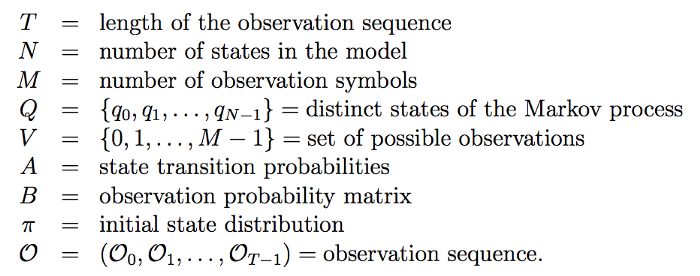

**State Transition Probabilities** are the probabilities of moving from state i to state j.
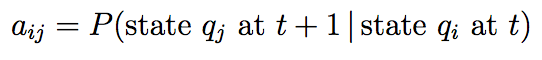

**Observation Probability Matrix** also called emission probabilities, express the probability of an observation Ot being generated from a state i.
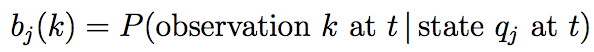

**Initial State Distribution** $\pi$<sub>i</sub> is the probability that the Markov chain will start in state i. Some state j with $\pi$<sub>j</sub>=0 means that they cannot be initial states.

Hence, the entire Hidden Markov Model can be described as,
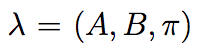

In [1]:
import hmm

Let us take a simple example with two hidden states and two observable states.

The **Hidden states** will be **Rainy** and **Sunny**.

The **Observable states** will be **Sad** and **Happy**.

The transition and emission matrices are given below.

The initial probabilities are obtained by computing the stationary distribution of the transition matrix.
This means that for a given matrix A, the stationary distribution would be given as,
$\pi$A = $\pi$

In [2]:
# Hidden
hidden_states = ["Rainy", "Sunny"]
transition_matrix = [[0.5, 0.5], [0.3, 0.7]]

In [3]:
# Observable
observable_states = ["Sad", "Happy"]
emission_matrix = [[0.8, 0.2], [0.4, 0.6]]

In [4]:
# Inputs
input_seq = [0, 0, 1]

model = hmm.HiddenMarkovModel(
    observable_states, hidden_states, transition_matrix, emission_matrix
)

**************************************************
Observable States: ['Sad', 'Happy']
Emission Matrix:
       Sad  Happy
Rainy  0.8    0.2
Sunny  0.4    0.6
Hidden States: ['Rainy', 'Sunny']
Transition Matrix:
       Rainy  Sunny
Rainy    0.5    0.5
Sunny    0.3    0.7
Initial Probabilities: [0.375 0.625]


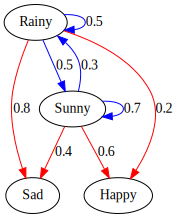

In [5]:
model.print_model_info()
model.visualize_model(notebook=True)

Here the <span style="color: blue;">blue</span> lines indicate the hidden transitions.

Here the <span style="color: red;">red</span> lines indicate the emission transitions.

# Problem 1:
Computing Likelihood: Given an HMM $\lambda$ = (A, B) and an observation sequence O, determine the likelihood P(O | $\lambda$)

## How It Is Calculated?
For our example, for the given **observed** sequence - (Sad, Sad, Happy) the probabilities will be calculated as,

<em>

P(Sad, Sad, Happy) = 

P(Rainy) * P(Sad | Rainy) * P(Rainy | Rainy) * P(Sad | Rainy) * P(Rainy | Rainy) * P(Happy | Rainy)

+

P(Rainy) * P(Sad | Rainy) * P(Rainy | Rainy) * P(Sad | Rainy) * P(Sunny | Rainy) * P(Happy | Sunny)

+

P(Rainy) * P(Sad | Rainy) * P(Sunny | Rainy) * P(Sad | Sunny) * P(Rainy | Sunny) * P(Happy | Rainy)

+

P(Rainy) * P(Sad | Rainy) * P(Sunny | Rainy) * P(Sad | Sunny) * P(Sunny | Sunny) * P(Happy | Sunny)

+

P(Sunny) * P(Sad | Sunny) * P(Rainy | Sunny) * P(Sad | Rainy) * P(Rainy | Rainy) * P(Happy | Rainy)

+

P(Sunny) * P(Sad | Sunny) * P(Rainy | Sunny) * P(Sad | Rainy) * P(Sunny | Rainy) * P(Happy | Sunny)

+

P(Sunny) * P(Sad | Sunny) * P(Sunny | Sunny) * P(Sad | Sunny) * P(Rainy | Sunny) * P(Happy | Rainy)

+

P(Sunny) * P(Sad | Sunny) * P(Sunny | Sunny) * P(Sad | Sunny) * P(Sunny | Sunny) * P(Happy | Sunny)

</em>

## The Problems With This Method
This however, is a naive way of computation. The number of multiplications this way is of the order of 2TN<sup>T</sup>. 

where T is the length of the observed sequence and N is the number of hidden states.

This means that the time complexity increases exponentially as the number of hidden states increases.

# Forward Algorithm
We are computing *P(Rainy) * P(Sad | Rainy)* and *P(Sunny) * P(Sad | Sunny)* a total of 4 times.

Even parts like

*P(Rainy) * P(Sad | Rainy) * P(Rainy | Rainy) * P(Sad | Rainy)*, 

*P(Rainy) * P(Sad | Rainy) * P(Sunny | Rainy) * P(Sad | Sunny)*, 

*P(Sunny) * P(Sad | Sunny) * P(Rainy | Sunny) * P(Sad | Rainy)* and 

*P(Sunny) * P(Sad | Sunny) * P(Sunny | Sunny) * P(Sad | Sunny)* are repeated.

We can avoid so many computation by using recurrance relations with the help of **Dynamic Programming**.

![ForwardHMM](../assets/ForwardHMM.png)


In code, it can be written as:

```
alpha[:, 0] = self.pi * emission_matrix[:, input_seq[0]] # Initialize

for t in range(1, T):
    for s in range(n_states):
        alpha[s, t] = emission_matrix[s, input_seq[t]] * np.sum(
            alpha[:, t - 1] * transition_matrix[:, s]
        )
```

This will lead to the following computations:

![Computation](../assets/Computation.png)

In [6]:
alpha, a_probs = model.forward(input_seq)
hmm.print_forward_result(alpha, a_probs)

**************************************************
Alpha:
[[0.3    0.18   0.0258]
 [0.25   0.13   0.1086]]
Probability of sequence: 0.13440000000000002


# Backward Algorithm
The Backward Algorithm is the time-reversed version of the Forward Algorithm.

In [7]:
beta, b_probs = model.backward(input_seq)
hmm.print_backward_result(beta, b_probs)

**************************************************
Beta:
[[0.256  0.4    1.    ]
 [0.2304 0.48   1.    ]]
Probability of sequence: 0.13440000000000002


# Problem 2: 
Given an observation sequence O and an HMM λ = (A,B), discover the best hidden state sequence Q.

## Viterbi Algorithm
The Viterbi Algorithm increments over each time step, finding the maximum probability of any path that gets to state i at time t, that also has the correct observations for the sequence up to time t.

The algorithm also keeps track of the state with the highest probability at each stage. At the end of the sequence, the algorith will iterate backwards selecting the state that won which creates the most likely path or sequence of hidden states that led to the sequence of observations.

In code, it is written as:
```
delta[:, 0] = self.pi * emission_matrix[:, input_seq[0]] # Initialize
for t in range(1, T):
    for s in range(n_states):
        delta[s, t] = (
            np.max(delta[:, t - 1] * transition_matrix[:, s])
            * emission_matrix[s, input_seq[t]]
        )
        phi[s, t] = np.argmax(delta[:, t - 1] * transition_matrix[:, s])
```

The Viterbi Algorithm is identical to the forward algorithm except that it takes the **max** over the
previous path probabilities whereas the forward algorithm takes the **sum**.

The code for the Backtrace is written as:
```
path[T - 1] = np.argmax(delta[:, T - 1]) # Initialize
for t in range(T - 2, -1, -1):
    path[t] = phi[path[t + 1], [t + 1]]
```

In [8]:
path, delta, phi = model.viterbi(input_seq)
hmm.print_viterbi_result(input_seq, observable_states, hidden_states, path, delta, phi)

**************************************************
Starting Forward Walk
State=0 : Sequence=1 | phi[0, 1]=0.0
State=1 : Sequence=1 | phi[1, 1]=1.0
State=0 : Sequence=2 | phi[0, 2]=0.0
State=1 : Sequence=2 | phi[1, 2]=0.0
**************************************************
Start Backtrace
Path[1]=0
Path[0]=0
**************************************************
Viterbi Result
Delta:
[[0.3   0.12  0.012]
 [0.25  0.07  0.036]]
Phi:
[[0. 0. 0.]
 [0. 1. 0.]]
Result:
  Observation BestPath
0         Sad    Rainy
1         Sad    Rainy
2       Happy    Sunny
